In [11]:
from typing import TypedDict, Literal
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

# --- 1. SETUP QWEN (LOCAL) ---
# Using the 0.5b version as requested.
llm = ChatOllama(model="qwen2.5:0.5b", temperature=0)

# --- 2. DEFINE STATE ---
class GraphState(TypedDict):
    user_message: str
    sentiment: Literal["happy", "angry"]
    final_response: str

# --- 3. DEFINE NODES ---

def classification_node(state: GraphState):
    # 1. Extract input
    message = state["user_message"]
    
    # 2. Prompt for Qwen
    # Qwen 0.5B is smart but needs strict rules to avoid conversational filler.
    prompt = ChatPromptTemplate.from_template(
        """You are a strict data classifier.
        Task: Classify the text below as either "happy" or "angry".
        Constraint: Return ONLY the classification word. Do not say "The text is...". 
        
        Text: {text}
        Classification:"""
    )
    
    chain = prompt | llm
    response = chain.invoke({"text": message})
    
    # 3. Clean Output
    sentiment = response.content.strip().lower()
    
    # Debug print to see what the raw model output was
    print(f"🧐 Raw Qwen Output: '{sentiment}'")
    
    # Fallback logic in case it adds punctuation like "happy."
    if "happy" in sentiment:
        sentiment = "happy"
    else:
        sentiment = "angry"
        
    return {"sentiment": sentiment}

def happy_node(state: GraphState):
    print("😄 Running Happy Node")
    return {"final_response": "Qwen is happy that you are happy! 🚀"}

def apology_node(state: GraphState):
    print("😔 Running Apology Node")
    return {"final_response": "Qwen apologizes for the issue."}

# --- 4. BUILD GRAPH (Standard LangGraph Setup) ---

def decide_mood(state: GraphState):
    if state["sentiment"] == "happy":
        return "happy_responder"
    else:
        return "apology_responder"

workflow = StateGraph(GraphState)

workflow.add_node("classifier", classification_node)
workflow.add_node("happy_responder", happy_node)
workflow.add_node("apology_responder", apology_node)

workflow.set_entry_point("classifier")

workflow.add_conditional_edges(
    "classifier", 
    decide_mood,
    {
        "happy_responder": "happy_responder", 
        "apology_responder": "apology_responder"
    }
)

workflow.add_edge("happy_responder", END)
workflow.add_edge("apology_responder", END)

app = workflow.compile()

# --- 5. RUN IT ---

# Test 1
print("--- TEST 1 ---")
result = app.invoke({"user_message": "This is the best day ever!"})
print(f"🤖 Final Result: {result['final_response']}\n")

# Test 2
print("--- TEST 2 ---")
result = app.invoke({"user_message": "I hate this bug, it is annoying."})
print(f"🤖 Final Result: {result['final_response']}")

--- TEST 1 ---
🧐 Raw Qwen Output: 'happy'
😄 Running Happy Node
🤖 Final Result: Qwen is happy that you are happy! 🚀

--- TEST 2 ---
🧐 Raw Qwen Output: 'angry'
😔 Running Apology Node
🤖 Final Result: Qwen apologizes for the issue.


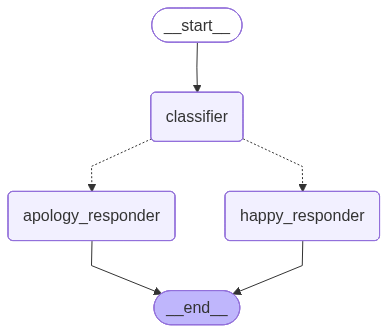

In [12]:
app